# 2 - Lines
>30DayMapChallenge classic: A map with focus on lines. Roads, rivers, routes, or borders—this day is all about mapping connections and divisions. Another traditional way to keep things moving. 📏

note to self use `osm` environment

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib import font_manager
import numpy as np
import osmnx as ox
import pandas as pd
import requests
import seaborn as sns
from shapely.geometry import box

font_manager.fontManager.addfont('../../../../../fonts/Borel/Borel-Regular.ttf')
ox.settings.max_query_area_size = 6_000_000_000_000

In [3]:
# nautral earth data
url = 'https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_50m_admin_0_countries.geojson'
response = requests.get(url)
data = response.json()

# convert to geodataframe
world = gpd.GeoDataFrame.from_features(data,
                                       crs='EPSG:4326')
france = (world
          .loc[world['admin'] == 'France']
          .explode(index_parts=False)
          .iloc[[-1]])

france_geo = france.iloc[0].geometry
crs = france.estimate_utm_crs()
minx, miny, maxx, maxy = france.to_crs(crs).buffer(100_000).total_bounds

In [4]:
key_values = {'shop':'bakery',
              'landuse':'farmland'}

data_frames = []

for key, value in key_values.items():
    df = (ox.features_from_polygon(france_geo,
                                  tags={key:value})
          .to_crs(crs)
          .reset_index(drop=True))
    
    df['geometry'] = df.centroid
    df['x'] = df.geometry.x
    df['y'] = df.geometry.y
    df['type'] = value
    df = df[['geometry', 'x', 'y', 'type']]
    data_frames.append(df)
    
combined = pd.concat(data_frames)

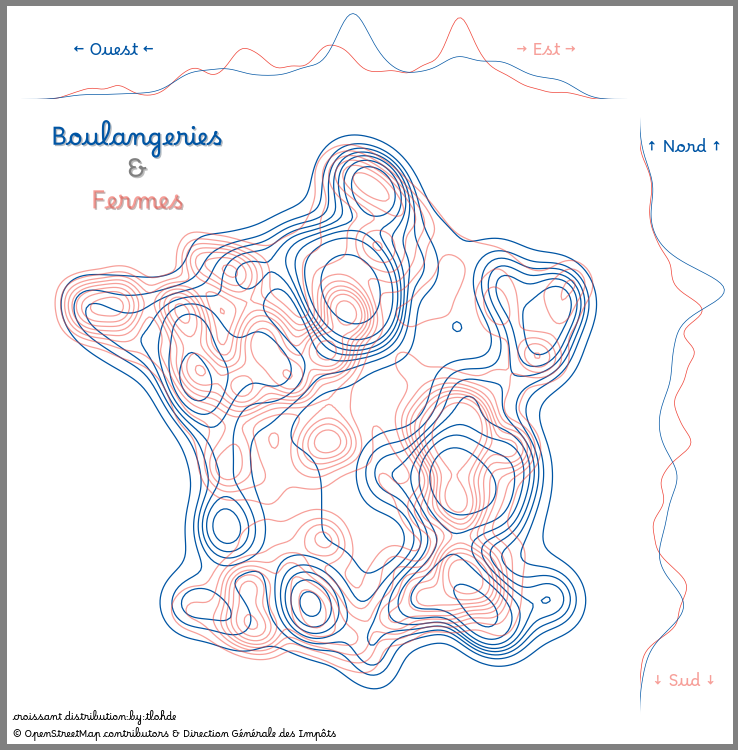

In [ ]:
# lighter version of french flag colours from 
# https://en.wikipedia.org/wiki/Flag_of_France
blue = (0/255, 85/255, 164/255, 1)
red = (239/255, 65/255, 53/255, 0.5)  # add some transparency to the reds

# do the plotting
jg = sns.jointplot(data=combined, # .sample(frac=0.20),
                   hue='type',
                   x='x',
                   y='y',
                   kind='kde', # levels=20,
                   palette=[blue, red],
                   hue_order=['bakery', 'farmland'],
                   linewidths=0.9,
                   fill=False,
                   joint_kws={'common_norm':False,
                              'common_grid': False},
                   marginal_kws={'common_norm':False,
                                 'linewidth':0.5},
                   legend=False,
                   ratio=7,
                   space=0.01,
                   height=8,
                   xlim=(minx, maxx),
                   ylim=(miny, maxy)
                   )

jg.ax_joint.set_aspect('equal')  # because we're plotting in metres

# remove axes
for ax in [jg.ax_joint, jg.ax_marg_x, jg.ax_marg_y]:
    ax.set_axis_off()
    
## annotations
# east west
jg.ax_marg_x.annotate('← Ouest ←',
                      xy=(0.1, 0.5),
                      xycoords='axes fraction',
                      font='Borel',
                      color=blue,
                      fontsize=12,
                      ha='left')

jg.ax_marg_x.annotate('→ Est →',
                      xy=(0.9, 0.5),
                      xycoords='axes fraction',
                      font='Borel',
                      color=red,
                      fontsize=12,
                      ha='right')

# north south
jg.ax_marg_y.annotate('↑ Nord ↑',
                      xy=(0.5, 0.92),
                      xycoords='axes fraction',
                      font='Borel',
                      color=blue,
                      fontsize=12,
                      ha='center')

jg.ax_marg_y.annotate('↓ Sud ↓',
                      xy=(0.5, 0.08),
                      xycoords='axes fraction',
                      font='Borel',
                      color=red,
                      ha='center',
                      fontsize=12)

## bakeries and farms
jg.ax_joint.annotate('Boulangeries',
                     xy=(0.2, 0.93),
                     xycoords='axes fraction',
                     font='Borel',
                     color=blue,
                     ha='center',
                     fontsize=18,
                     path_effects=[path_effects.withSimplePatchShadow(offset=(1,-1))])

jg.ax_joint.annotate('&',
                     xy=(0.2, 0.88),
                     xycoords='axes fraction',
                     font='Borel',
                     color='gray',
                     ha='center',
                     fontsize=18,
                     path_effects=[path_effects.withSimplePatchShadow(offset=(1,-1))])

jg.ax_joint.annotate('Fermes',
                     xy=(0.2, 0.83),
                     xycoords='axes fraction',
                     font='Borel',
                     color=red,
                     ha='center',
                     fontsize=18,
                     path_effects=[path_effects.withSimplePatchShadow(offset=(1,-1))])

# attribution
jg.ax_joint.annotate('croissant distribution:by:tlohde\n© OpenStreetMap contributors & Direction Générale des Impôts',
                     xy=(0,0),
                     xycoords='axes fraction',
                     font='Borel',
                     fontstyle='italic',
                     fontsize=7)

jg.figure.patch.set_edgecolor('gray')
jg.figure.patch.set_linewidth(8)

jg.figure.savefig('day2_lines.png', bbox_inches='tight', dpi=300)